In [103]:
# Add module import path to system path.
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Hot-loading modules before executing code: allows us to write code while testing it in this notebook.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
import logging

# Logging strategy for this notebook.
root = logging.getLogger()
root.setLevel(logging.INFO)

if not root.hasHandlers():
    handler = logging.StreamHandler(sys.stdout)
    handler.setLevel(logging.INFO)

    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    handler.setFormatter(formatter)

    root.addHandler(handler)

In [108]:
from parser import Parser
from span import Span

parser = Parser()
seasons, teams = parser.parse()

train_seasons = []
for year in range(1985, 2016):
    train_seasons.append(seasons[year])
train_span = Span(train_seasons, classifier_type="MLP")

test_seasons = []
for year in range(2016, 2022):
    if year != 2020:
        test_seasons.append(seasons[year])
test_span = Span(test_seasons)

2022-03-14 10:11:17,575 - parser - INFO - Column names are TeamID, TeamName, FirstD1Season, LastD1Season
2022-03-14 10:11:17,576 - parser - INFO - Processed 372 teams.
2022-03-14 10:11:17,577 - parser - INFO - Column names are Season, DayNum, WTeamID, WScore, LTeamID, LScore, WLoc, NumOT
2022-03-14 10:11:18,067 - parser - INFO - Processed 174471 games.
2022-03-14 10:11:18,068 - parser - INFO - Column names are Season, DayNum, WTeamID, WScore, LTeamID, LScore, WLoc, NumOT
2022-03-14 10:11:18,075 - parser - INFO - Processed 2317 games.
2022-03-14 10:11:18,077 - parser - INFO - Column names are Season, Seed, TeamID
2022-03-14 10:11:18,081 - parser - INFO - Processed 2354 seeds.
2022-03-14 10:11:18,083 - parser - INFO - Column names are Season, RankingDayNum, SystemName, TeamID, OrdinalRank
2022-03-14 10:11:22,865 - parser - INFO - Processed 4521720 ranking rows.
2022-03-14 10:11:22,866 - parser - INFO - Column names are Season, DayZero, RegionW, RegionX, RegionY, RegionZ
2022-03-14 10:11:

In [109]:
# 50/50 predictions
span_predictions = test_span.predict()

scores = Span.score(span_predictions)
assert scores['Average'] == 0.6931471805599453, f"50/50 classifier should yield a 0.69314 score, but yielded {scores['Average']}"

In [102]:
def get_span_predictions(max_iter):
    classifier = train_span.train(max_iter)
    classifiers = test_span.build_seasons_classifiers_map(classifier)
    span_predictions = test_span.predict(classifiers)
    return span_predictions

def get_scores(span_predictions):
    scores = Span.score(span_predictions)
    return scores

def get_average_score(max_iter):
    return get_scores(max_iter)['Average']

span_predictions = get_span_predictions(50000)

get_scores(span_predictions)

{2016: 0.5743177992752647,
 2017: 0.5276268202909352,
 2018: 0.6215496643397742,
 2019: 0.5033544525544482,
 2021: 0.6197598057056414,
 'Average': 0.5693217084332127}

In [63]:
system_names = ['COL', 'DOL', 'MOR', 'POM', 'SAG', 'WLK']
n = 100
max_iter = 50000

def get_system_score():
    total = 0
    for i in range(n):
        total += get_average_score(max_iter)
    total = total / n
    return total


In [8]:
# COL
get_system_score()

0.6103558013513964

In [9]:
# DOL
get_system_score()

0.5847185901459864

In [10]:
# MOR
# 0.5480336305395394 without 2021
get_system_score()

0.5693132996313941

In [11]:
# POM
get_system_score()

0.5739430038960476

In [12]:
# SAG
# 0.5529249194596761 without 2021
get_system_score()

0.5778776467600932

In [499]:
# WLK
get_system_score()

0.5648090590121495

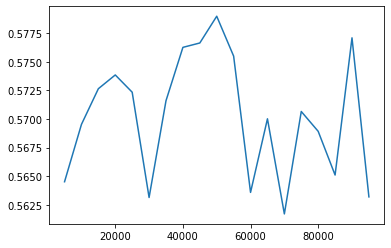

In [23]:
import numpy as np
from matplotlib import pyplot as plt

d = {}
for x in range(5000, 100000, 5000):
    d[x] = get_average_score(x)


lists = sorted(d.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.show()

In [343]:
# Build UI that lets you pick the features to use. 

In [405]:
# 3 point PCT
# Look at coaches


In [422]:
keys = seasons[2003].tournament.rankings.keys()
for year in range(2004, 2022):
    if year != 2020:
        keys = keys & seasons[year].tournament.rankings.keys()
keys

{'AP', 'COL', 'DOL', 'MOR', 'POM', 'SAG', 'USA', 'WLK'}

In [410]:
{1, 2} & {2, 3}

{2}

In [481]:
len(seasons[2016].tournament.rankings["POM"])

351

In [90]:
lines = ["ID,Pred"]

for year in range(2016, 2022):
    if year != 2020:
        for prediction in span_predictions[year]:
            lines.append(f"{year}_{prediction.team_1_id}_{prediction.team_2_id},{prediction.win_p}")
            
with open('submission.csv', 'w') as f:
    for line in lines:
        f.write(line)
        f.write('\n')